Andrew Carr

## Imports

In [1]:
from ipyparallel import Client

import numpy as np
import keras
from keras.layers import Dense, Conv2D, Activation
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adadelta, Adagrad, Adam, Nadam
from keras.utils import np_utils
from keras.datasets import cifar10
from sklearn.model_selection import GridSearchCV, train_test_split
from matplotlib import pyplot as plt

plt.style.use("ggplot")

%matplotlib inline 
import tensorflow as tf

Using TensorFlow backend.


## Code

I use parallel processing, so my code quality is probably lower because by their very nature they are harder to understand and use. Sorry for that.

In [2]:
# Load and properly reshape  data
(tr_x, tr_y), (t_x, t_y) = cifar10.load_data()

In [3]:
client = Client()
dview = client[:]

a = """
import numpy as np
import keras
from keras.layers import Dense, Conv2D, Activation
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adadelta, Adagrad, Adam, Nadam
from keras.utils import np_utils
from keras.datasets import cifar10
from sklearn.model_selection import GridSearchCV, train_test_split
from matplotlib import pyplot as plt
import tensorflow as tf
"""
dview.execute(a)

<AsyncResult: execute>

In [4]:
dview.block = True

In [5]:
# Reshape y as one-hot
y_train = np_utils.to_categorical(tr_y, 10).astype(float)
y_test = np_utils.to_categorical(t_y, 10).astype(float)

# Flatten each image
input_dim = tr_x.shape[1]*tr_x.shape[2]*tr_x.shape[3]
x_train = tr_x.reshape((tr_x.shape[0], input_dim))
x_test = t_x.reshape((t_x.shape[0], input_dim))

# Permute the training data to be in random order
perm = np.random.permutation(x_train.shape[0])
x_train = x_train[perm]
y_train = y_train[perm]

# Build Keras neural network
def build_keras_model(optimizer):
    """Build a basic DNN in keras"""
    output_dim = 10 # number of classes
    model = Sequential()
    model.add(Dense(512, input_dim=input_dim, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Generate optimizers for each run
def generate_optimizers(learning_rate=.01):
    """Generate a dictionary of optimizers for keras to use in gridsearch"""
    sgd = SGD()
    momentum = SGD(lr=learning_rate, momentum=.9)
    nesterov = SGD(lr=learning_rate, momentum=.9, nesterov=True)
    rmsprop = RMSprop(lr=learning_rate)
    adagrad = Adagrad(lr=learning_rate)
    adadelta = Adadelta(lr=learning_rate)
    adam = Adam(lr=learning_rate)
    nadam = Nadam(lr=learning_rate)
    optimizer_dict = {'SGD':sgd,
                      'Momentum':momentum,
                      'Nesterov':nesterov, 
                      'RMSprop':rmsprop, 
                      'AdaGrad':adagrad, 
                      'AdaDelta':adadelta, 
                      'Adam':adam,
                      'Nadam':nadam}
    return optimizer_dict

In [6]:
dview.push({"input_dim":input_dim, "x_train":x_train, "y_train":y_train, "x_test":x_test, "y_test": y_test, "build_keras_model": build_keras_model, "generate_optimizers":generate_optimizers})

[None, None, None, None, None]

I'm using 1 engine for each learning rate

In [7]:
learning_rates = [.0001, .001, .01, .1, 1]
dview.scatter("learning_rates",learning_rates)

In [8]:
dview['learning_rates']

[[0.0001], [0.001], [0.01], [0.1], [1]]

In [19]:

learning_rate_loop = """
for learning_rate in learning_rates:
    # this will only execute once on each engine
    optimizer_dict = generate_optimizers(learning_rate)
    # optimizer_dict = {"SGD":SGD(), "Momentum":SGD(lr=learning_rate, momentum=0.9)}
    accuracy = []
    for name, opt in optimizer_dict.items():
        dnn = build_keras_model(opt)

        hist = dnn.fit(x_train,
                        y_train,
                        batch_size=128,
                        epochs=20,
                        verbose=2,
                        shuffle=False,
                        validation_data=(x_test, y_test))

        # Save accuracy of each model across epochs.
        accuracy.append(np.array([name, float(hist.history['acc'][-1])]))

    # plot accuracy across learning rate
    plt.barh(range(8), list(np.array(accuracy)[:,1]))
    plt.title("Learning Rate {}".format(learning_rate))
    plt.yticks(np.arange(len(accuracy)), np.array(accuracy)[:,0])
    plt.tight_layout()
    plt.savefig("lr_{}".format(str(learning_rate).split(".")[-1]), dpi=300, pad_inches=0.5)
    """

This was the fastest way to code it up, in my opinion, without using map or anything like that

In [20]:
dview.execute(learning_rate_loop)

<AsyncResult: execute:finished>

## Plots

These plots show accuracy for learning rates accross each optimizer. 

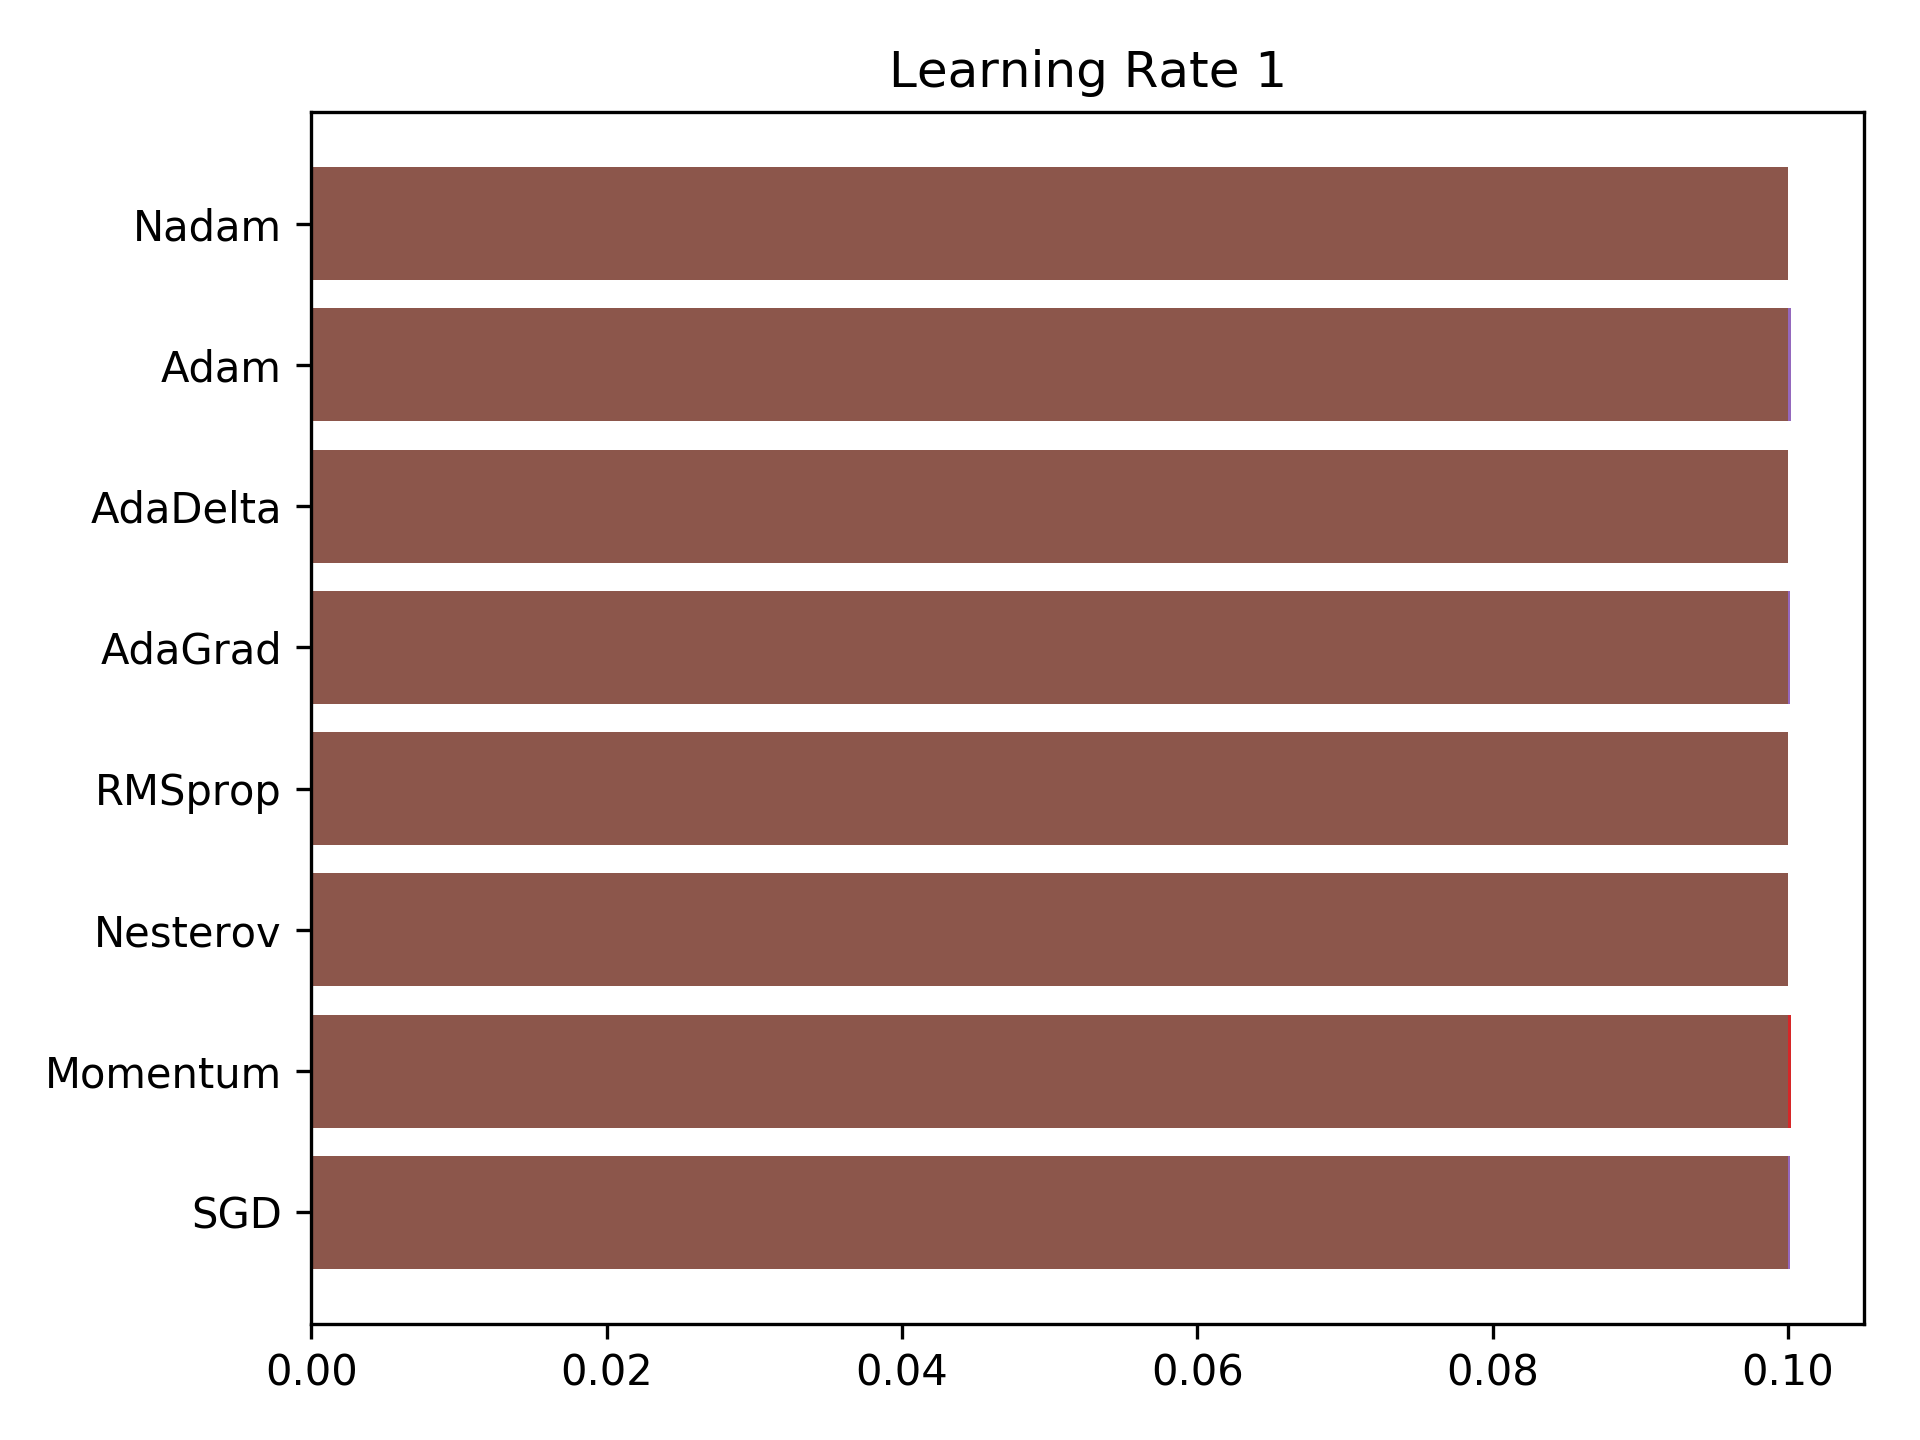

In [22]:
from IPython.display import Image
Image("lr_1.png")

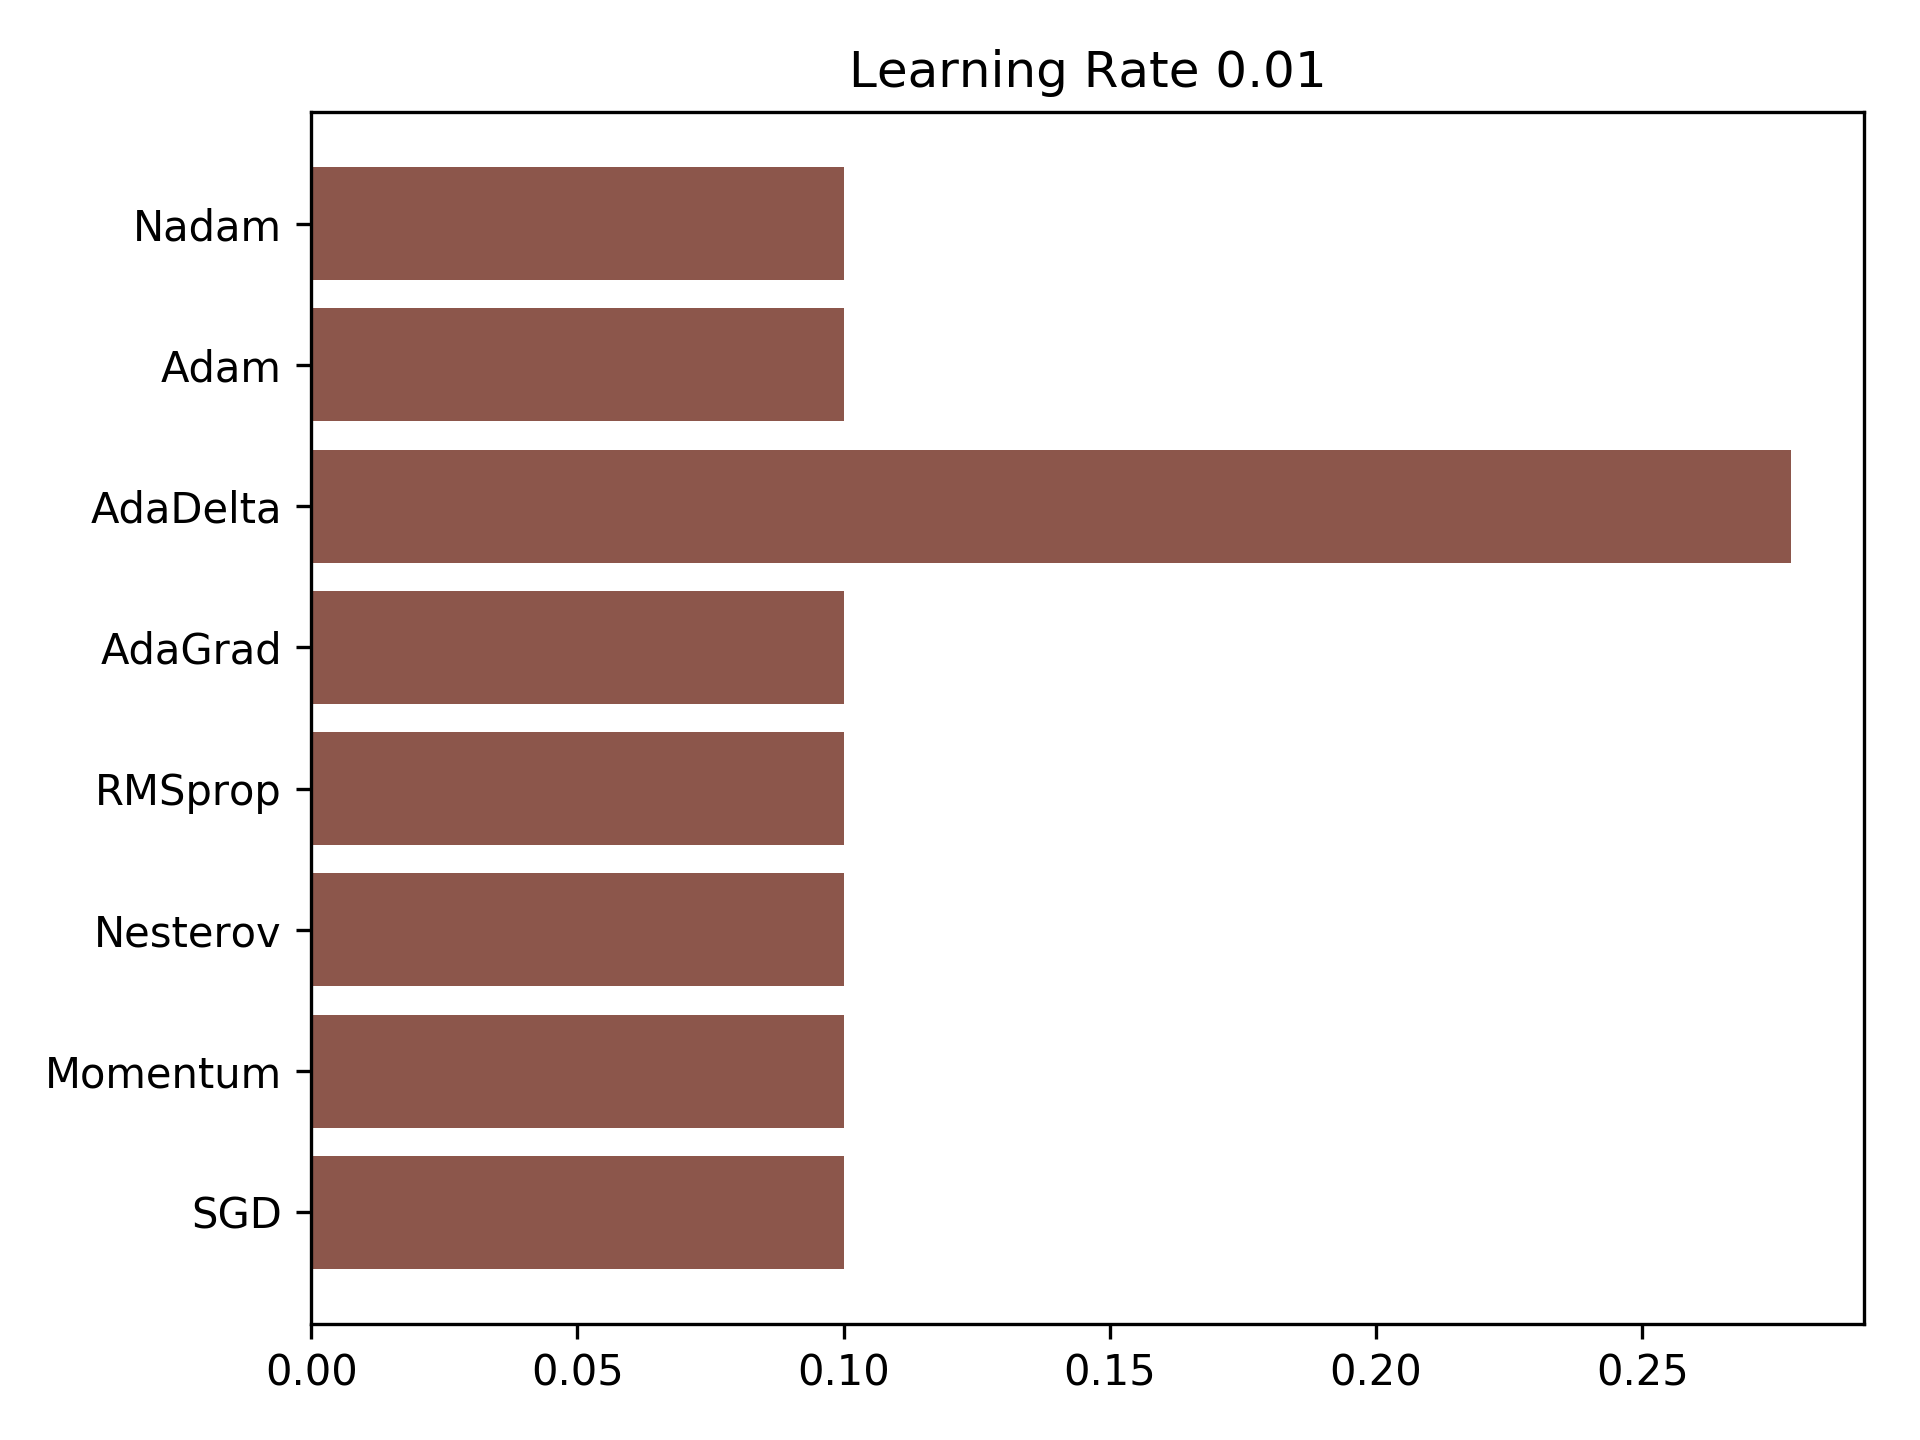

In [23]:
Image("lr_01.png")

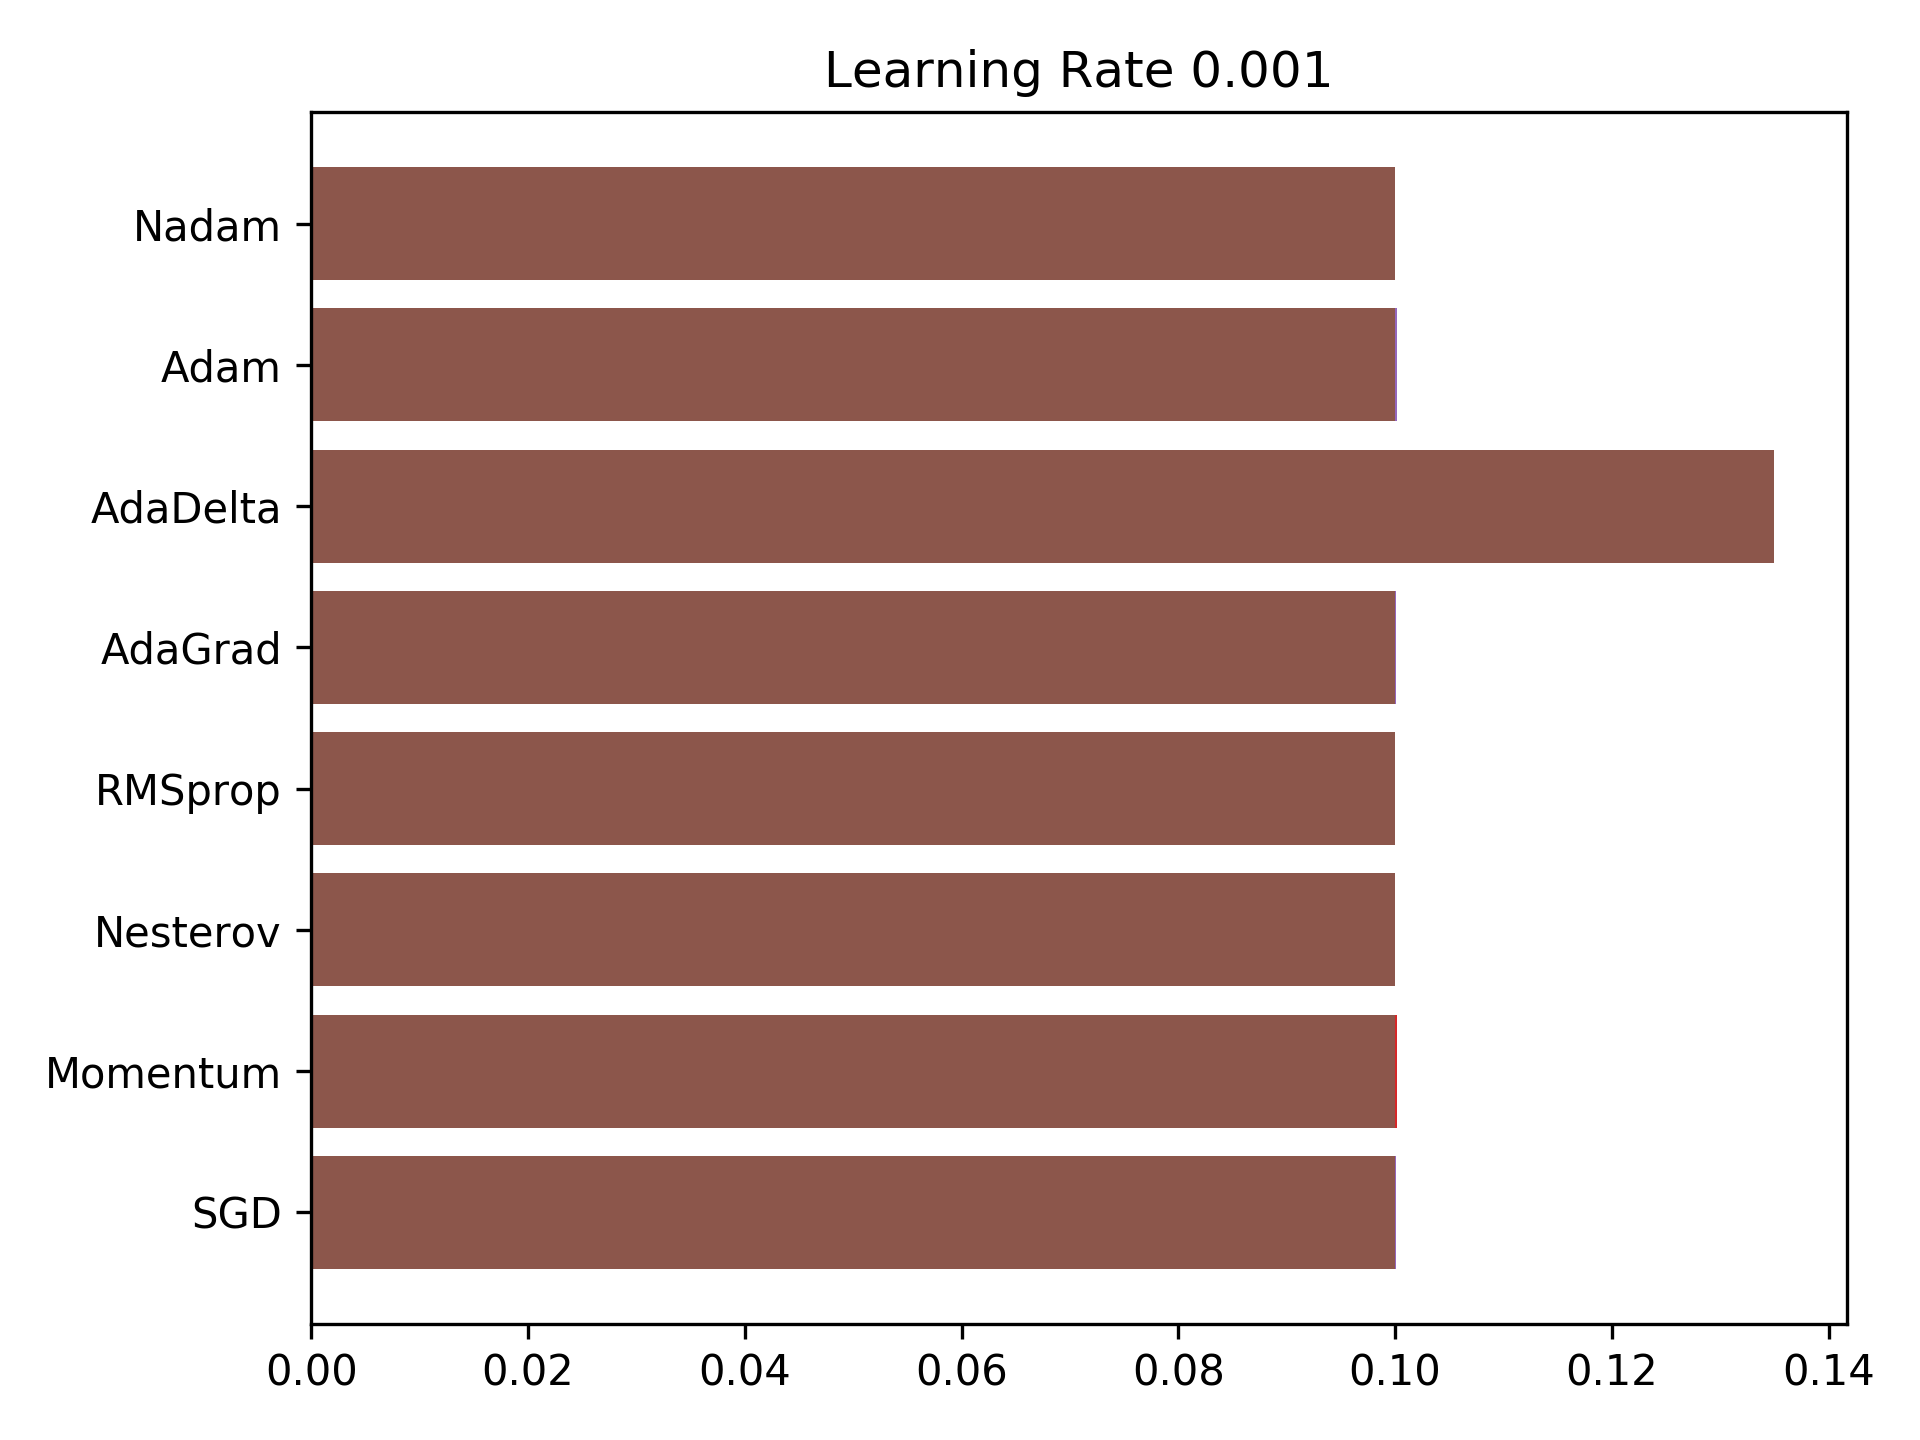

In [24]:
Image("lr_001.png")

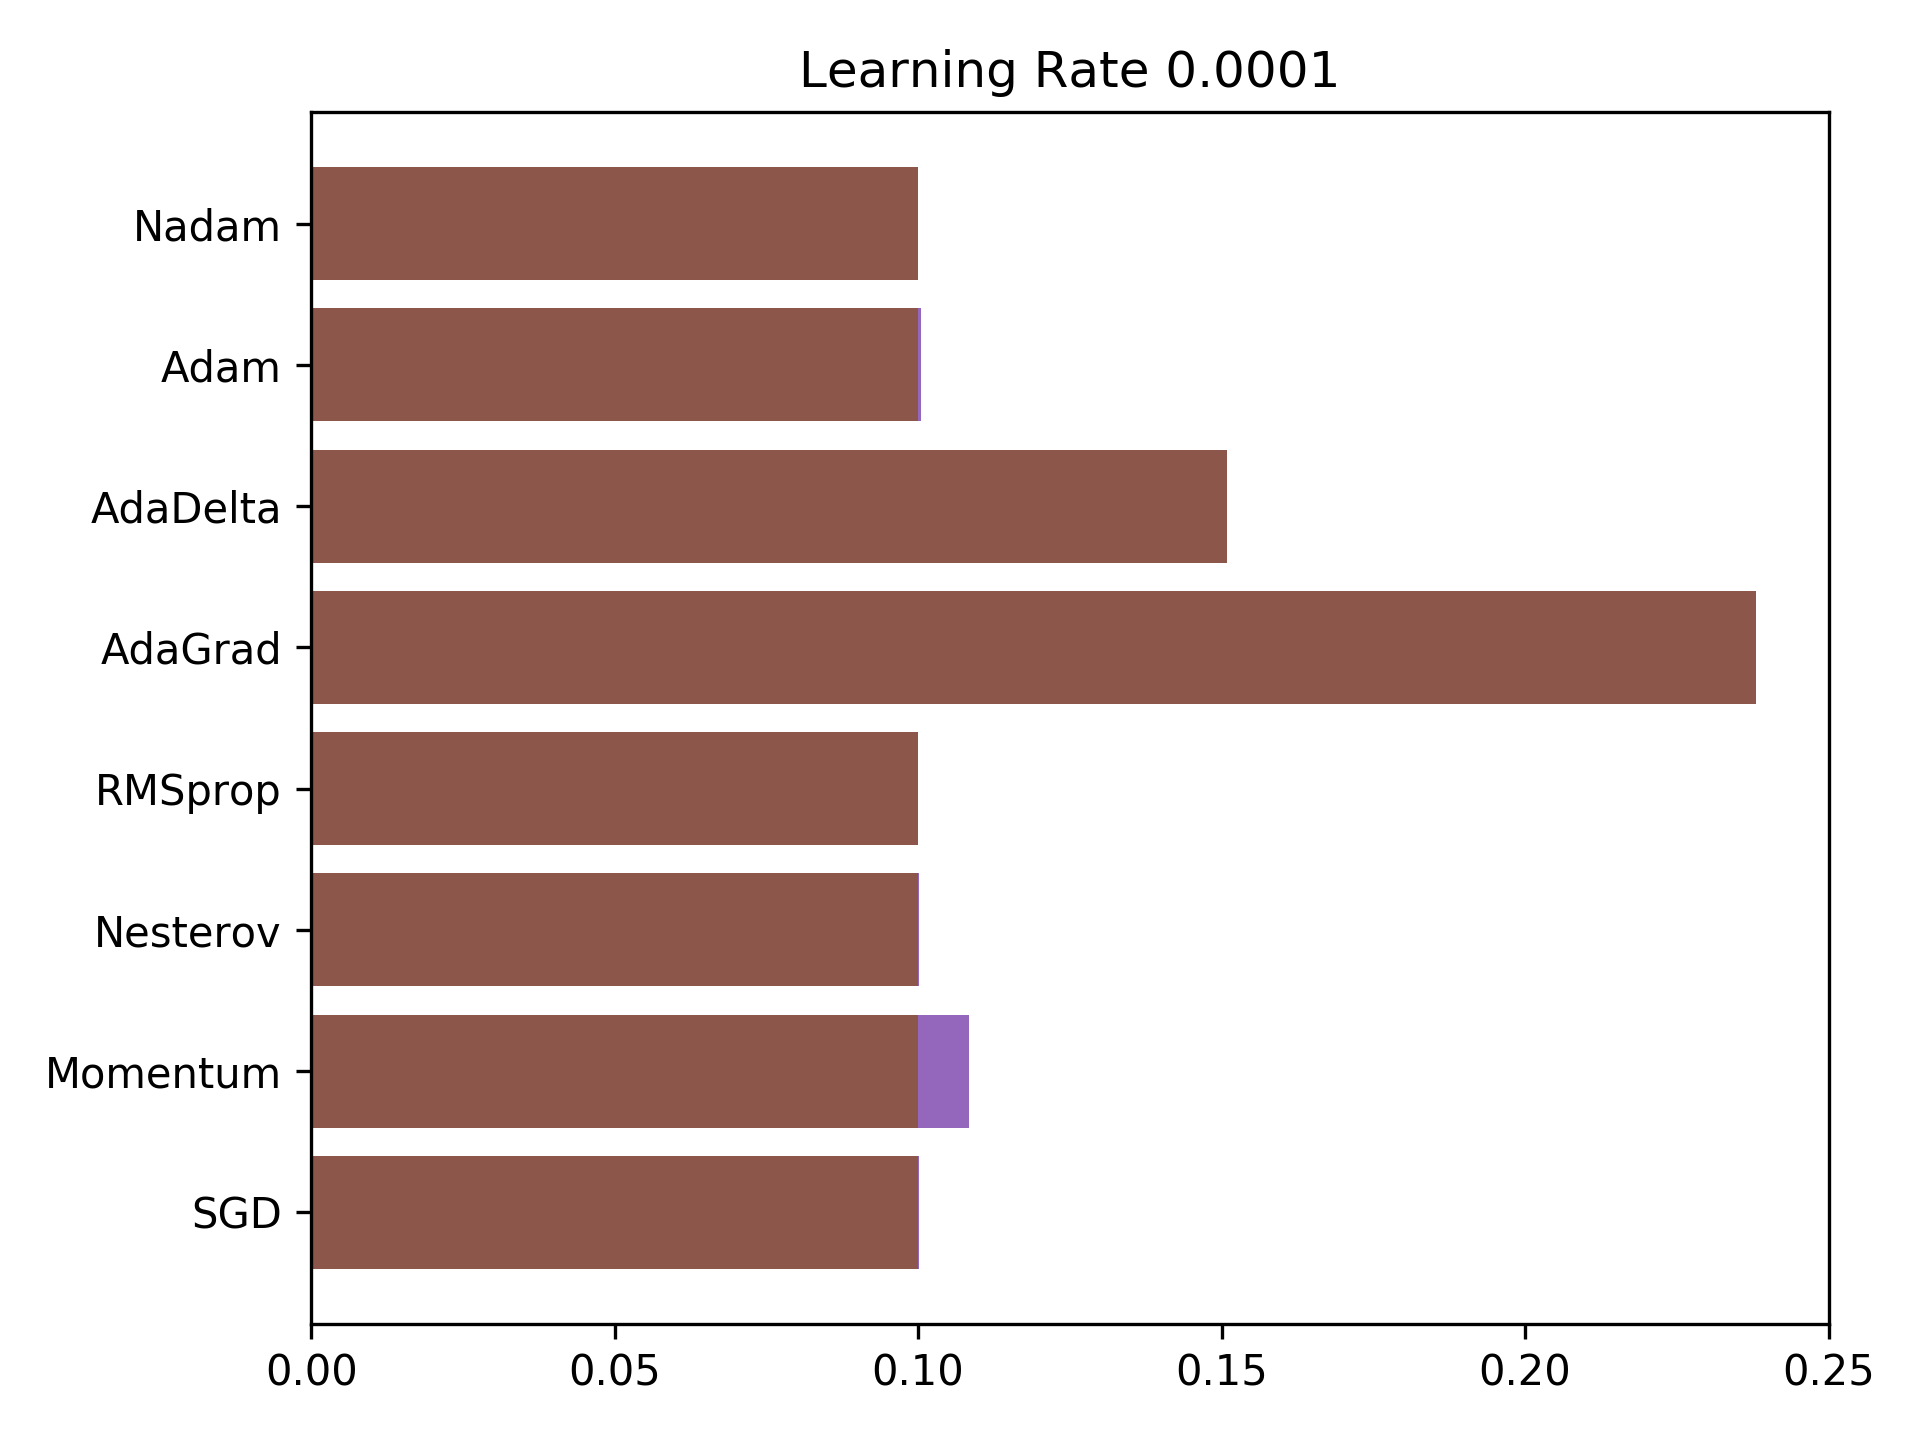

In [25]:
Image("lr_0001.png")

It is interesting to observe that Adam doesn't do great with this architecture (batch size etc) compared to methods like AdaGrad and AdaDelta. It really appreciated the fact that I was able to use parallel processing to significantly reduce computation time. 